In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dest_train_path ='/content/drive/MyDrive/training_data_aug'
dest_val_path = '/content/drive/MyDrive/Validation_data'

1) From the '360 rocks' folder create a training dataset that has 30 categories and 12 images in each category. To create the categories, group the rocks by name
From  '120 rocks' folder create a validation dataset that has 30 categories and 4 images in each category.

We have manually created the training set which has 30 sub folders in it each containing 12 images in each category.
We have done the same with validation data.

2)Build the input pipeline, including the appropriate preprocessing operations, and add data augmentation.

Code to Augment data

In [ ]:
import os
from PIL import Image

input_directory = '/content/drive/MyDrive/training_data'

for filename in os.listdir(input_directory):
  path1=input_directory+'/'+filename
  for filename1 in os.listdir(path1):

    if filename1.endswith(".jpeg") or filename1.endswith(".png") or filename1.endswith(".jpg"):
        img_path = os.path.join(path1, filename1)
        img = Image.open(img_path)
        rotated_img = img.rotate(90, expand=True)
        output_path = os.path.join(path1, f"{filename1[:-4]}_rotated.png")
        rotated_img.save(output_path)
        img = Image.open(output_path)
        rotated_img = img.rotate(90, expand=True)
        output_path = os.path.join(path1, f"{filename1[:-4]}_rotated1.png")
        rotated_img.save(output_path)
        img = Image.open(output_path)
        rotated_img = img.rotate(90, expand=True)
        output_path = os.path.join(path1, f"{filename1[:-4]}_rotated2.png")
        rotated_img.save(output_path)



This is a pipeline to preprocess all the images from the augumented images

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,

    #horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    dest_train_path,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    dest_val_path,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1466 images belonging to 30 classes.
Found 120 images belonging to 30 classes.


3) Fine-tune a pretrained neural network of your choice on the training data from the previous step. Before fine-tuning, you should remove the top layer of the pretrained network and add at least two more layers with a softmax activation function (your output layer should have 30 neurons and the layer before the output layer should have 8 neurons). For fine-tuning, you should first train for a few epochs only weights in the layers that you added

In [ ]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import get_file

# Download and cache the VGG16 weights
weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                         'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                         cache_subdir='models',
                         file_hash='6d6bbae143d832006294945121d1f1fc')

# Load pretrained VGG16 model with downloaded weights
base_model = VGG16(weights=weights_path, include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
"""model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='elu'),

    Dense(128, activation='elu'),
    Dense(64,activation="elu"),
    BatchNormalization(),



    Dense(8, activation='elu'),
    BatchNormalization(),
    Dense(30, activation='softmax')
])"""

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='elu'),  # Increase the number of neurons in the first Dense layer

    Dense(128, activation='elu'),  # Add another Dense layer with more neurons
    Dropout(0.5),  # Add a Dropout layer for regularization

    Dense(64, activation='elu'),  # Add another Dense layer with more neurons
    Dropout(0.5),  # Add a Dropout layer for regularization

    Dense(32, activation='elu'),  # Add another Dense layer with more neurons
    BatchNormalization(),  # Add BatchNormalization for stabilization

    Dense(8, activation='elu'),  # Keep the existing Dense layer
    BatchNormalization(),  # Add BatchNormalization for stabilization

    Dense(30, activation='softmax')  # Keep the existing output layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

3) After that, you should train all the weights

In [ ]:
from scipy import ndimage  # Explicitly import ndimage from SciPy
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import procrustes

# Your previous code for downloading VGG16 and setting up the model

# Step 4: Fine-tune the Pretrained VGG16 Model

# Train only the custom layers
history_initial = model.fit(train_generator, validation_data=val_generator, epochs=40)

# Unfreeze the base model
base_model.trainable = True

# Compile the model again
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_finetune = model.fit(train_generator, validation_data=val_generator, epochs=70, initial_epoch=40)

# Plotting
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()

Epoch 1/40
46/46 [==============================] - 33s 711ms/step - loss: 2.8355 - accuracy: 0.1146 - val_loss: 3.5568 - val_accuracy: 0.0417
Epoch 2/40
46/46 [==============================] - 32s 702ms/step - loss: 2.8295 - accuracy: 0.1173 - val_loss: 3.2337 - val_accuracy: 0.0750
Epoch 3/40
46/46 [==============================] - 32s 683ms/step - loss: 2.7928 - accuracy: 0.1289 - val_loss: 3.2258 - val_accuracy: 0.0500
Epoch 4/40
46/46 [==============================] - 32s 696ms/step - loss: 2.7498 - accuracy: 0.1323 - val_loss: 3.2332 - val_accuracy: 0.0500
Epoch 5/40
46/46 [==============================] - 31s 682ms/step - loss: 2.7817 - accuracy: 0.1180 - val_loss: 3.3951 - val_accuracy: 0.0833
Epoch 6/40
46/46 [==============================] - 31s 671ms/step - loss: 2.7518 - accuracy: 0.1323 - val_loss: 3.2874 - val_accuracy: 0.0500
Epoch 7/40
46/46 [==============================] - 32s 687ms/step - loss: 2.7336 - accuracy: 0.1337 - val_loss: 3.3855 - val_accuracy: 0.0417

Display train and validation loss and accuracy during the training and make a plot showing train and validation loss and accuracy as a function of the training epoch

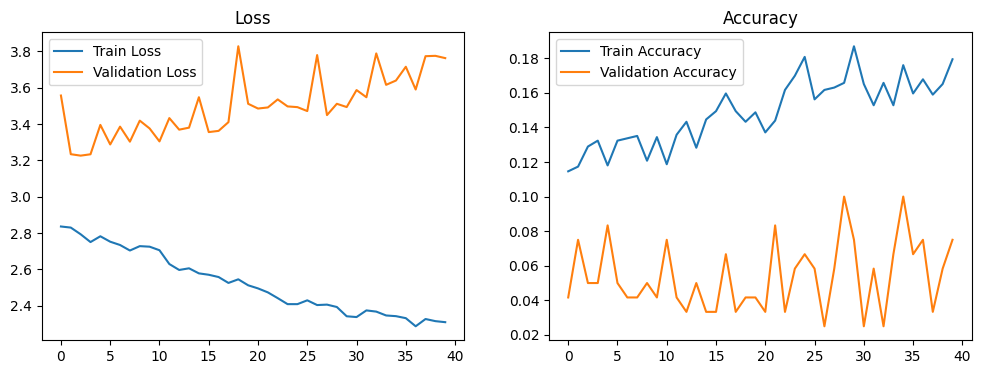

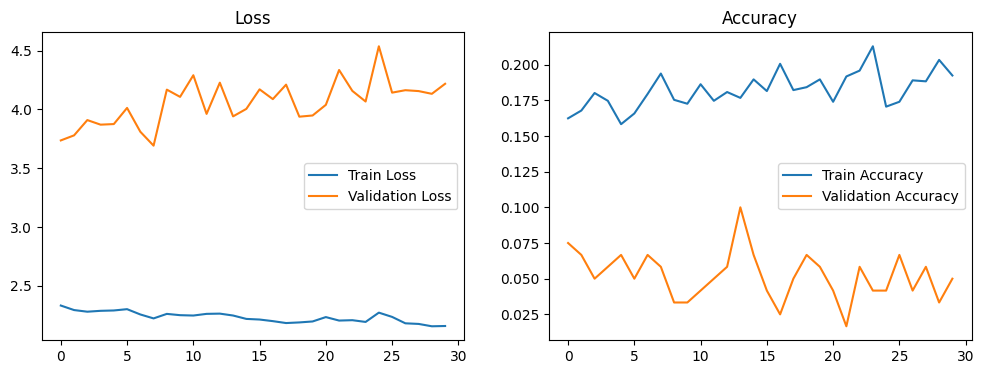

In [ ]:
plot_history(history_initial)
plot_history(history_finetune)

The first two are the plots showing the train and validation loss and accuracy for the base model without finetuning for 40 epochs.(froze the base model in our case vgg16)

Then we fine tuned it and the results for 30 epochs are in the next two plots.

 3) Discuss your findings - comment on the performance of the network , convergence , and possible hyperparameter tweaks you tried, or you would try to improve the performance

As we can see the performance of the network is noot that great but we did try with a lot of other hyper parametersbut these are the best parameters we obtained.

The train accuracy we obtained was 21% and the validation accuracy was 10%.

We first tried with 20 epochs as suggested but the network didn't converge, so we trained it for another 50 epochs. So in total we trained it for 70 epochs.

The hyperparameter tweaks we tried were -
- We used 6 dense layers
- We first used Relu as our activation function, which led to vanishing gradient which meant the Relu was dying. Then we used ELU as our activation function and used BatchNormalization.
- We used dropout to be 0.5 to avoid overfitting of the model as we faced this issue initially training our model.

In [ ]:
model.save('/content/drive/My Drive/models/latest_vgg16_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/My Drive/models/latest_vgg16_model.h5'

# Load the model
loaded_model = load_model(model_path)

In [4]:
path_360 ='/content/drive/MyDrive/forhw4_360'
path_120='/content/drive/MyDrive/forhw4_120'

In [5]:
import numpy as np
from skimage import io
import os
def get_img_lab(path):
    image_list=[]
    #label_list=[]
    #label_encode = {'I': 0, 'M': 1, 'S': 2}
    for image in os.listdir(path):
        single_image = io.imread(os.path.join(path,image))

        resize_g_img = np.resize(single_image, (150, 150, 3))

        image_list.append(np.array(resize_g_img))
        #label_list.append(label_encode[image[0]])

    return np.array(image_list)

images_360= get_img_lab(path_360)

In [6]:
import numpy as np
from skimage import io
import os
def get_img_lab(path):
    image_list=[]
    #label_list=[]
    #label_encode = {'I': 0, 'M': 1, 'S': 2}
    for image in os.listdir(path):
        single_image = io.imread(os.path.join(path,image))

        resize_g_img = np.resize(single_image, (150, 150, 3))

        image_list.append(np.array(resize_g_img))
        #label_list.append(label_encode[image[0]])

    return np.array(image_list)

images_120= get_img_lab(path_120)

In [ ]:
images_360.shape

(360, 150, 150, 3)

In [ ]:
import numpy as np

# Assuming you have your model loaded as 'model'
# Assuming 'images_360' is your array of images

# Reshape the images array to fit the model input shape
images_reshaped = images_360.reshape(-1, 150, 150, 3)

# Normalize pixel values to the range [0, 1] (if required by the model)
images_normalized = images_reshaped / 255.0

# Make predictions using the model
predictions = loaded_model.predict(images_normalized)


12/12 [==============================] - 2s 190ms/step


In [ ]:
predictions.shape

(360, 30)

4) Compute the correlation coefficients between the network data and human data for each of the 8 neurons in your next-to-last layer (similar to HW3, using procrustes analysis) for the images from the train set (360 images) and (separately) for the images from the validation set (120 images). Report each of the 8 correlation coefficients and your average correlation coefficients.

In [9]:
from tensorflow.keras.models import Model
penultimate_model=Model(inputs = loaded_model.input, outputs = loaded_model.layers[-2].output)

In [ ]:
penultimate_pred=penultimate_model(images_normalized)

In [ ]:
penultimate_pred.shape

TensorShape([360, 8])

In [ ]:
print("Shape of human_data:", human_data.shape)
print("Shape of network_data:", network_data.shape)


Shape of human_data: (360, 8)
Shape of network_data: (360, 8)


In [ ]:
import numpy as np

# Load the human data from the text file
human_data = np.loadtxt('/content/drive/MyDrive/mds_360.txt')  # Adjust the file path as needed

# Load the network data from penultimate_pred
network_data = penultimate_pred.numpy()  # Assuming penultimate_pred is a TensorFlow tensor

# Calculate the correlation coefficients between human_data and network_data
correlation_coefficients = np.corrcoef(human_data.T, network_data.T)[human_data.shape[1]:, :human_data.shape[1]]

# Print or use the correlation coefficients as needed
print("Correlation coefficients:", correlation_coefficients)


Correlation coefficients: [[-0.0785862  -0.00564767  0.09136356  0.07513919 -0.04298654 -0.04428143
   0.02660954 -0.00736616]
 [ 0.06131596  0.00402699 -0.11420465 -0.07741169  0.0446779   0.03579576
  -0.03163551  0.00244018]
 [-0.07884306 -0.00562573  0.09100579  0.07514732 -0.0429778  -0.04434682
   0.02657722 -0.00751376]
 [-0.07383278 -0.0052691   0.0984036   0.07593755 -0.04339014 -0.04212704
   0.02828331 -0.00593074]
 [-0.07901344 -0.00561678  0.09080871  0.07509187 -0.04294874 -0.04446054
   0.02658134 -0.00759537]
 [-0.07382599 -0.00523929  0.09843179  0.07593725 -0.04344569 -0.0421105
   0.02831218 -0.00594713]
 [ 0.06757923  0.00470635 -0.10665612 -0.07686295  0.0440931   0.03898696
  -0.02999055  0.00406757]
 [-0.07384074 -0.00524619  0.09839147  0.07604741 -0.0434677  -0.04205024
   0.02825927 -0.00596266]]


In [ ]:
network_data.shape

(360, 8)

In [ ]:
type(network_data)

numpy.ndarray

In [ ]:
mtx1, mtx2, disparity = procrustes(human_data, network_data)


print("Transformation matrix for array1:", mtx1)
print("Transformation matrix for array2:", mtx2)
print("Disparity:", disparity)


Transformation matrix for array1: [[-0.02752123 -0.00393436  0.01071516 ... -0.01529132  0.02959598
   0.01280227]
 [ 0.01639672  0.0165173   0.0033702  ... -0.00021824  0.04242074
   0.00566696]
 [ 0.00203934  0.01554135 -0.03118582 ... -0.02826067 -0.00108514
  -0.02008377]
 ...
 [-0.02558378 -0.02003399 -0.01953943 ... -0.01726491  0.00197285
  -0.00813376]
 [-0.00083069 -0.01227696  0.01066455 ...  0.05165192 -0.01047599
  -0.00980372]
 [ 0.00773602 -0.03065382  0.00335574 ...  0.03305095 -0.00167794
  -0.00809038]]
Transformation matrix for array2: [[ 2.37438454e-04  1.46533101e-05 -3.09134263e-04 ...  1.31297791e-04
  -8.21992059e-05  8.08122111e-06]
 [ 2.37438454e-04  1.46533101e-05 -3.09134263e-04 ...  1.31297791e-04
  -8.21992059e-05  8.08122111e-06]
 [ 2.37438454e-04  1.46533101e-05 -3.09134263e-04 ...  1.31297791e-04
  -8.21992059e-05  8.08122111e-06]
 ...
 [ 2.37438454e-04  1.46533101e-05 -3.09134263e-04 ...  1.31297791e-04
  -8.21992059e-05  8.08122111e-06]
 [ 2.37438454e-

The disparity of 360 dataset is **0.9964843446166347**

In [7]:
import numpy as np

# Assuming you have your model loaded as 'model'
# Assuming 'images_360' is your array of images

# Reshape the images array to fit the model input shape
images_reshaped = images_120.reshape(-1, 150, 150, 3)

# Normalize pixel values to the range [0, 1] (if required by the model)
images_normalized = images_reshaped / 255.0

# Make predictions using the model
predictions = loaded_model.predict(images_normalized)


4/4 [==============================] - 33s 8s/step


In [10]:
penultimate_pred=penultimate_model(images_normalized)

In [11]:
import numpy as np

# Load the human data from the text file
human_data = np.loadtxt('/content/drive/MyDrive/mds_120.txt')  # Adjust the file path as needed

# Load the network data from penultimate_pred
network_data = penultimate_pred.numpy()  # Assuming penultimate_pred is a TensorFlow tensor

# Calculate the correlation coefficients between human_data and network_data
correlation_coefficients = np.corrcoef(human_data.T, network_data.T)[human_data.shape[1]:, :human_data.shape[1]]

# Print or use the correlation coefficients as needed
print("Correlation coefficients:", correlation_coefficients)


Correlation coefficients: [[ 0.05972022  0.08887403  0.00607444 -0.03894687  0.13497123 -0.02920232
   0.09111766 -0.03481746]
 [-0.06179602 -0.09346203  0.01039397  0.04304732 -0.13226437  0.03084002
  -0.07826985  0.03895035]
 [ 0.05985733  0.08873336  0.00633841 -0.03893116  0.13510678 -0.02938745
   0.091131   -0.03492861]
 [ 0.06022332  0.08998289  0.00194935 -0.03988878  0.13429877 -0.03014246
   0.0880403  -0.03610379]
 [ 0.05980085  0.08848566  0.00687736 -0.03885074  0.13522901 -0.02957464
   0.09139091 -0.03485739]
 [ 0.0602738   0.09000784  0.00180703 -0.0400553   0.13429072 -0.03003753
   0.08779599 -0.03607458]
 [-0.06111477 -0.09202418  0.00485684  0.04167445 -0.13316163  0.03017273
  -0.08273497  0.03751293]
 [ 0.06047595  0.09010173  0.00148783 -0.04022471  0.13454691 -0.03002706
   0.08721089 -0.03608589]]


In [14]:
from scipy.spatial import procrustes
mtx1, mtx2, disparity = procrustes(human_data, network_data)



print("Disparity:", disparity)


Disparity: 0.9949834544919631


The disparity of validation data(120 images ) is **0.9949834544919631**